### Bears

Let's train a model to classify bear photos. We will then export the model and create an application we can deploy to Gradio.

In [1]:
# Temp fix for MPS device
# https://github.com/pytorch/pytorch/issues/77764
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


#### Step 1: Assemble Data

In [2]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_results=10):
    print(f'Searching for {term}..')
    with DDGS() as ddgs:
        results = ddgs.images(term)
        return L([ next(results).get("image") for _ in range(max_results)])

Let's download pictures of different kind of bears and store them in folders accordingly. 

In [3]:
from fastai.vision.all import *

bears_types = ['black', 'grizzly', 'teddy']

path = Path('bears')

if not path.exists():
    path.mkdir()

    for bear_type in bears_types:
        dest = (path/bear_type)
        dest.mkdir()
        download_images(dest, urls=search_images(f'{bear_type} bear', max_results=25))

Verify images were downloaded correctly and remove any failed.

In [4]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f'{len(failed)} images removed.')

0 images removed.


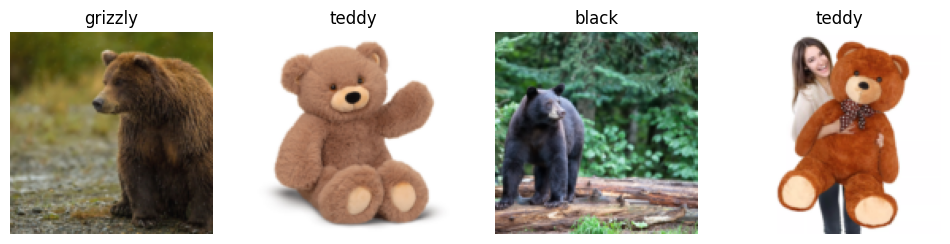

In [5]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

dls = bears.dataloaders(path)

dls.valid.show_batch(max_n=4, nrows=1)

By default, images are cropped to fit the requested size.

But we can also `Squish` them:

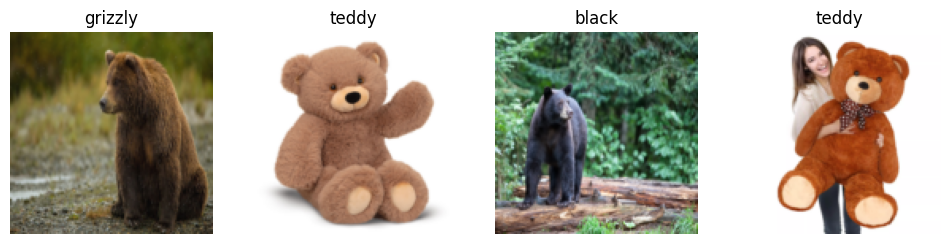

In [6]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Or `Pad` them with zeros (black):

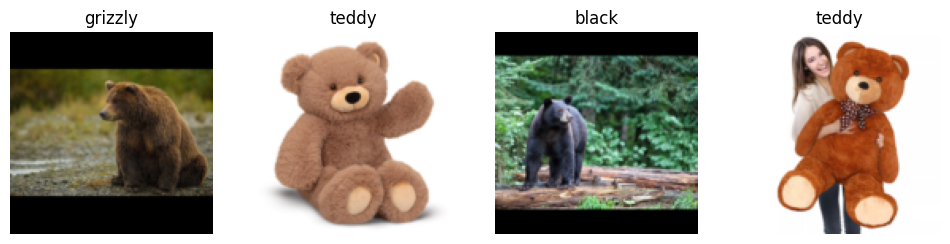

In [7]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Squish or stretch will lead to unrealistic shapes. Padding leads to wasted computation.

Instead for each training epoch, let's crop a random part of the image - this way our model is exposed to different photos of the same thing just framed in a slightly different way.

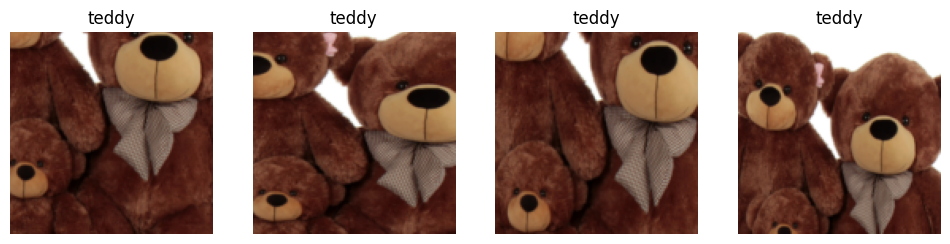

In [8]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path, bs=4)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

This technique is an example of **Data augmentation**: creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes.

/Users/clapis/.pyenv/versions/3.12.1/envs/ds/lib/python3.12/site-packages/torch/_tensor.py:1418: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  ret = func(*args, **kwargs)


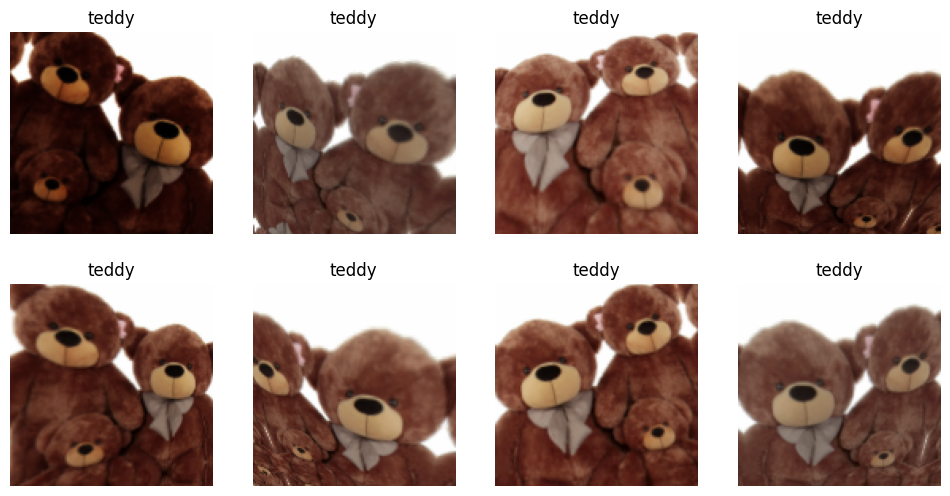

In [9]:
# aug_transforms provides a standard set of augumentations that generally work well
# Using Resize instead of RandomResizedCrop and double the amount of augumentations (mult=2) to visualize the concept 
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path, bs=8)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

#### Step 2: Train Model

In [10]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

dls = bears.dataloaders(path, bs=5)

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.652547,0.169620,0.000000,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.482647,0.105313,0.076923,00:04
1,0.276002,0.093023,0.076923,00:04
2,0.267489,0.073885,0.076923,00:03
3,0.313046,0.052647,0.000000,00:03


Let's use a _confusion matrix_ to visualize the mistakes the model is making:

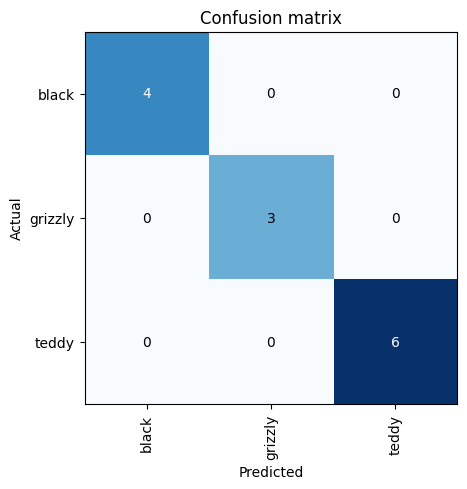

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

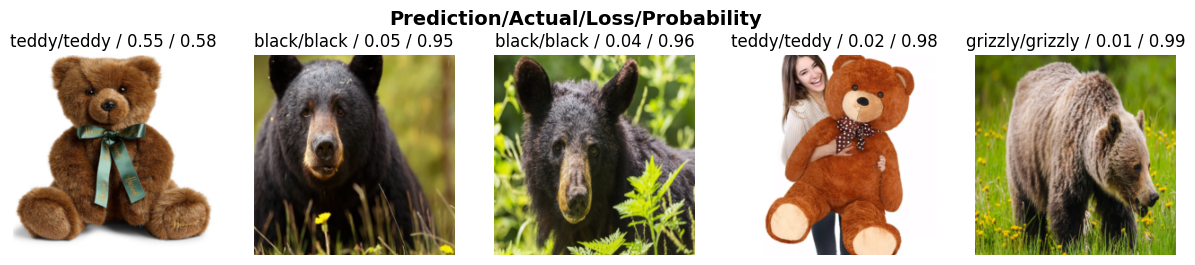

In [13]:
interp.plot_top_losses(5, nrows=1)

Let's export our model, so we can create an application and use it for _inference_

In [14]:
learn.export()

Let's try it out on a teddy picture:

In [15]:
learn_inf = load_learner('export.pkl')

In [37]:
label, _, probs = learn_inf.predict('teddy.jpg')

print(f'Image is most likely a {label}. Probabilites:')

for l,p in zip(learn_inf.dls.vocab, probs.numpy()):
    print(f"{l}: {p:.0%}")


Image is most likely a teddy. Probabilites:
black: 0%
grizzly: 0%
teddy: 100%
